importazione delle librerie necessarie per svolgere il progetto:

In [128]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle
import json
import csv
import requests
from serpapi import GoogleScholarSearch
import matplotlib.pyplot as plt

## Primo punto
1. A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per
ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.

In [19]:
#creazione di un dataframe a partire da node.csv fornito
nodesDf = pd.read_csv("./nodes.csv")

display(nodesDf)

,Unnamed: 0,name,affiliations,author_id,cited_by,interests
0,0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,"[{'title': 'Computer Science', 'serpapi_link':..."
1,1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"[{'title': 'Computer Science', 'serpapi_link':..."
2,2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"[{'title': 'Artificial Intelligence', 'serpapi..."
3,3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"[{'title': 'Information retrieval', 'serpapi_l..."
4,4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"[{'title': 'Information Retrieval', 'serpapi_l..."
5,5,Gianluca Demartini,Associate Professor at the University of Queen...,PCAiILsAAAAJ,5348,"[{'title': 'Information Retrieval', 'serpapi_l..."
6,6,Eddy Maddalena,"Università degli Studi di Udine, Italy",egHDpFkAAAAJ,553,"[{'title': 'Information Retrieval', 'serpapi_l..."


ricerca degli autori presenti nel dataframe utilizzando SerpAPI, i JSON di tutti gli autori vengono salvati dentro un array

In [ ]:
results = []
for index, row in nodesDf.iterrows():
    # Per trovare il json
    params = {
        "api_key": "defe59bb41320b50cef9e862104451a72a6598012023c6eb73869e48a3dd9c2f",
        "engine": "google_scholar_profiles",
        "hl" : "en",
        "mauthors" : row['name'],
        "affilations" : row['affiliations']
    }
    search = GoogleScholarSearch(params)
    result = search.get_dict() #salva i risultati json come dizionario
    results.append(result) #array dei json
    

ricerca dei dati richiesti per ogni autore per poi creare un dataframe con le colonne:
* author_id
* cited_by
* interests 

il dataframe appena creano viene poi concatenato al dataframe 'nodesDf' creato in precedenza in modo da avere un dataframe
che contiene tutti i dati di nostro interesse per ognuno dei 7 autori presenti in nodes.csv

In [ ]:

author_id = []
cited_by = []
interests = []

#item : richiesta API 
for item in results: 
    #info: singolo profilo di ogni richiesta
    for info in item['profiles']:
        #selezione del profilo info corretto 
        for index, row in nodesDf.iterrows():
            if (info['name'] == row['name'] and info['affiliations'] == row['affiliations']):
                author_id.append(info['author_id']) 
                cited_by.append(info['cited_by'])
                interests.append(info['interests']) 
                
filtered_results = pd.DataFrame({
    'author_id': author_id,
    'cited_by': cited_by,
    'interests':interests
    })

nodesDf1 = pd.concat([nodesDf,filtered_results], axis=1)
display(nodesDf1)



### aggiornamento del file originale nodes.csv
aggiunta al file originale nodes.csv : author_id , cited_by, interests 

In [ ]:
nodesDf1.to_csv('nodes.csv')

## Secondo punto
Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google
Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. Con tale elenco
di nomi: 
1. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che
corrisponde a tale nome. Per ciascuno, salvare name, affiliations,
author_id, cited_by e interests in un nuovo DataFrame contenente tutte
queste informazioni relative ai coautori dei 7 autori originari.
2. Concatenare il DataFrame con i 7 autori originari e quello dei coautori
generato al punto 2a in un unico DataFrame.
NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non
accedere al loro profilo tramite id.
ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite
il valore di affiliations, quindi assumete che quello corretto sia il primo
ritornato nella lista di authors.
3. Creare un terzo DataFrame con le colonne author1, author2 che
rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un
arco di coauthorship tra due autori.
ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame
creato al punto 2c se Michael Soprano è coautore di David La Barbera. La
co-authorship è binaria, non pesata.
A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e
contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi
coautori con colonne author1, author2. Salvare come edges.csv nella
cartella /data tale DataFrame.


In [ ]:
resultsAuthors = []
for index, row in nodesDf.iterrows():
    # Per trovare il json
    params2 = {
        "api_key": "defe59bb41320b50cef9e862104451a72a6598012023c6eb73869e48a3dd9c2f",
        "engine": "google_scholar_author",
        "hl" : "en",
        "author_id" : row['author_id']
    }
    search = GoogleScholarSearch(params2)
    resultAuthor = search.get_dict() #salva i risultati json come dizionario
    resultsAuthors.append(resultAuthor) #array dei json
    
display(resultsAuthors)


ricerca dei coautori e filtraggio dei duplicati

In [ ]:
coAuthors_id =[]
for author in resultsAuthors:
    for coAuthor in author['co_authors']:  
        coAuthors_id.append(coAuthor['author_id'])
#fare un altro df nella quale teniamo per ogni autore i suoi coautori in modo da poter fare il grafo 

coAuthors_id = list(set(coAuthors_id)) #set rimuove i duplicati dall'array

display(coAuthors_id)

#buond

rimozione dei sette autori originali 

In [ ]:
for index, row in nodesDf.iterrows():
    if row['author_id'] in coAuthors_id:
        coAuthors_id.remove(row['author_id'])
#display(coAuthors_id)
print(len(coAuthors_id))

In [ ]:
resultsCoAuthors = []
for id in coAuthors_id:
    # Per trovare il json
    params2_1 = {
        "api_key": "defe59bb41320b50cef9e862104451a72a6598012023c6eb73869e48a3dd9c2f",
        "engine": "google_scholar_author",
        "hl" : "en",
        "author_id" : id
    }
    search = GoogleScholarSearch(params2_1)
    resultCoAuthor = search.get_dict() #salva i risultati json come dizionario
    resultsCoAuthors.append(resultCoAuthor) #array dei json
    

In [16]:
author_id = []
cited_by = []
interests = []
name = []
affiliations = []

for fileJ in resultsCoAuthors: 
    name.append(fileJ['author']['name'])
    affiliations.append(fileJ['author']['affiliations'])
    author_id.append(fileJ['search_parameters']['author_id']) 
    cited_by.append(fileJ['cited_by']['table'][0]['citations']['all'])
    #controllo per vedere se gli autori hanno il campo interests    
    if  'interests' in fileJ['author']:
        interests = (*interests, (fileJ['author']['interests']))
    else :
        interests = (*interests, [] )
       
                
coAuthorDf = pd.DataFrame({
    'name' : name,
    'affiliations':affiliations,
    'author_id': author_id,
    'cited_by': cited_by,
    'interests':interests
})
display(coAuthorDf)
#nodesDf1 = pd.concat([nodesDf,filtered_results], axis=1)
#display(nodesDf1)

,name,affiliations,author_id,cited_by,interests
0,Dante Degl'Innocenti,Datamantix,Ay6L7NsAAAAJ,117,"[{'title': 'Artificial Intelligence', 'link': ..."
1,Arkaitz Zubiaga,Queen Mary University of London,IUb-xxMAAAAJ,6611,"[{'title': 'Social Media Mining', 'link': 'htt..."
2,Marco Pavan,"PhD in Computer Science, University of Udine",-UudVuUAAAAJ,112,"[{'title': 'Data Mining', 'link': 'https://sch..."
3,Ujwal Gadiraju,"Assistant Professor, Web Information Systems, ...",FX7BF6QAAAAJ,3263,"[{'title': 'Human-centered AI', 'link': 'https..."
4,Karl Aberer,Professor of Computer and Communication Scienc...,ifU81ikAAAAJ,23830,"[{'title': 'Social Media', 'link': 'https://sc..."
...,...,...,...,...,...
64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


concatenazione del dataframe dei autori e dei co autori:

In [26]:
finalNodeDf = pd.concat( [nodesDf, coAuthorDf]) #dataframe con tutti gli autori di nostro interesse
finalNodeDf = finalNodeDf.drop('Unnamed: 0', axis=1)
display(finalNodeDf)

,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,"[{'title': 'Computer Science', 'serpapi_link':..."
1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"[{'title': 'Computer Science', 'serpapi_link':..."
2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"[{'title': 'Artificial Intelligence', 'serpapi..."
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"[{'title': 'Information retrieval', 'serpapi_l..."
4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"[{'title': 'Information Retrieval', 'serpapi_l..."
...,...,...,...,...,...
64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


creazione del terzo dataframe:

In [35]:
author_1 = []
author_2 = []
for originalAuthor in resultsAuthors:
    for coAuthor in originalAuthor['co_authors']:
        author_1.append(originalAuthor['author']['name'])
        author_2.append(coAuthor['name'])

edgesDf = pd.DataFrame({
    'author_1': author_1,
    'author_2': author_2
})
display(edgesDf)

,author_1,author_2
0,David La Barbera,Kevin Roitero
1,David La Barbera,Stefano Mizzaro
2,David La Barbera,Gianluca Demartini
3,David La Barbera,Damiano Spina
4,David La Barbera,Michael Soprano
...,...,...
122,Eddy Maddalena,Pavlos Vougiouklis
123,Eddy Maddalena,Jonathon Hare
124,Eddy Maddalena,Carlo Alberto Beltrami
125,Eddy Maddalena,Richard Gomer


eliminazione delle ridondanze di coautoraggio:

In [84]:

for index, row in edgesDf.iterrows():
    to_remove = {'author_1': row['author_2'], 'author_2': row['author_1']}
    is_present = (edgesDf == to_remove).all(axis=1).any()
    if is_present:
        edgesDf = edgesDf.drop(index)
edgesDf.to_csv('./data/edges.csv')


,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,"[{'title': 'Computer Science', 'serpapi_link':..."
1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"[{'title': 'Computer Science', 'serpapi_link':..."
2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"[{'title': 'Artificial Intelligence', 'serpapi..."
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"[{'title': 'Information retrieval', 'serpapi_l..."
4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"[{'title': 'Information Retrieval', 'serpapi_l..."
...,...,...,...,...,...
64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


aggiornamento del file contenente gli autori di interesse aggiungendo anche i 69 co-autori trovati:

In [85]:
finalNodeDf.to_csv('./data/nodes.csv')

### Terzo punto
Utilizzando i due DataFrame prodotti:
1. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
2. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con
grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo
visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella
/visualizations

creazione del grafo indiretto 'author_graph' utilizzando i dataframe 'finalNodeDf' e 'edges':

In [91]:
author_graph = nx.Graph()

for index, row in finalNodeDf.iterrows():
    author_graph.add_node(row['name'],
                          affiliations=row['affiliations'],
                          author_id =row['author_id'], 
                          cited_by=row['cited_by'], 
                          interests=row['interests'])
#print(author_graph.nodes())


['David La Barbera', 'Michael Soprano', 'Kevin Roitero', 'Stefano Mizzaro', 'Damiano Spina', 'Gianluca Demartini', 'Eddy Maddalena', "Dante Degl'Innocenti", 'Arkaitz Zubiaga', 'Marco Pavan', 'Ujwal Gadiraju', 'Karl Aberer', 'Víctor Fresno', 'Afshin Rahimi', 'Julio Gonzalo', 'Yunke Qu', 'Laura Sbaffi', 'Andrew Turpin', 'Dr. Wasim Ahmed, PhD', 'Luca Di Gaspero', 'Davide Ceolin', 'Claudio Carpineto', 'Fabio Crestani', 'Giuseppe Primiero', 'Falk Scholer', 'Edgar Meij', 'Michele Catasta', 'Luis-Daniel Ibáñez', 'Mattia Zeni', 'Lei Han', 'Elena Nazzi', 'Alberto Tonon', 'Philippe Cudre-Mauroux', 'J. Shane Culpepper', 'Tim Draws', 'Mihai Horia Popescu', 'Jorge Carrillo-de-Albornoz', 'Peter A Bath', 'Tetsuya Sakai', 'Omar Alonso', 'Alessandro Checco', 'Andrea Brunello', 'Vincenzo Della Mea', 'Hideo Joho', 'Yongli Ren', 'Luca Vassena', 'Giuseppe Serra', 'Tereza Iofciu', 'Wolfgang Nejdl', 'Jan Wielemaker', 'Flora Salim', 'Shaoyang Fan', 'Richard Gomer', 'Shazia Sadiq', 'Mark Sanderson', 'Paolo Cop

In [97]:
for index, row in edgesDf.iterrows():
    author_graph.add_edge(row['author_1'], row['author_2'])


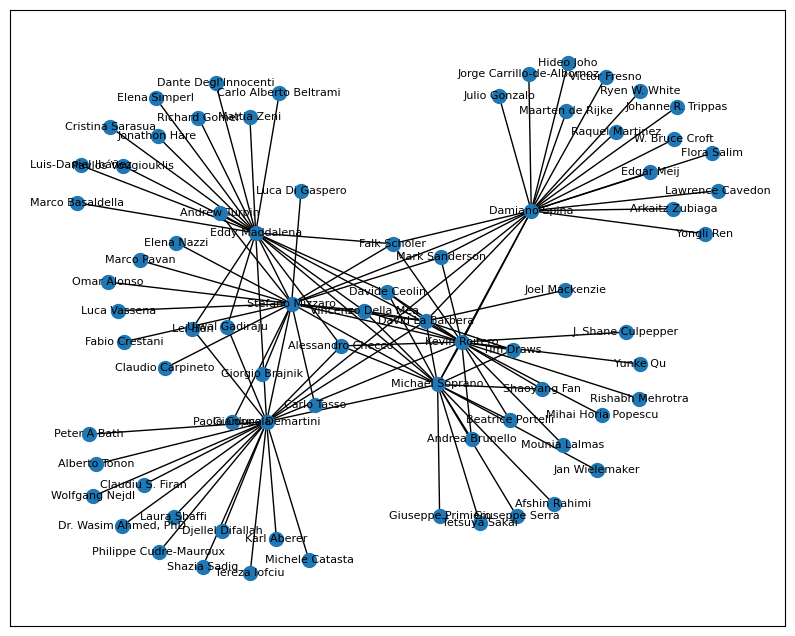

In [127]:
plt.figure(figsize=(10,8))
nx.draw_networkx(author_graph,pos = nx.spring_layout(author_graph), node_size=100, font_size=8)

plt.show(author_graph)

In [130]:
with open('./graphs/author_graph.pkl', 'wb') as f:
    pickle.dump(author_graph,f)